In [1]:
import tensorflow as tf
tf.python.control_flow_ops = tf

import os
import pandas as pd
import numpy as np
import cv2
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, \
MaxPooling2D, Conv2D, Lambda, Cropping2D, Convolution2D,\
AveragePooling2D
from keras.callbacks import History,TensorBoard, EarlyStopping, ModelCheckpoint
from sklearn.cross_validation import train_test_split

from copy import deepcopy
from sklearn.utils import shuffle


from generator import generator
from get_images import get_images


Using TensorFlow backend.
/root/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
datadirs=['/notebooks/udacity/new_training/map1_backward/',
                 '/notebooks/udacity/new_training/map1_forward/',
                 '/notebooks/udacity/new_training/map1_recovery_backward/',
                 '/notebooks/udacity/new_training/map1_recovery_forward/',
                   '/notebooks/udacity/new_training/map1_error_correction/'
         ]

images=get_images(datadirs)

In [3]:
size=(40,80)

def preprocessing_resize(im):
    return cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2YUV),(size[1],size[0]))

In [4]:
from car_models import *

In [5]:
grid=[{'get_model':modified_lenet, 'correction':0.2, \
       'preprocessing':preprocessing_resize,'optimizer':'adam','gpu':'0','name':'lenet_02_adam'},\
     {'get_model':nvidia_net, 'correction':0.2, \
       'preprocessing':lambda x:x,'optimizer':'adam','gpu':'0','name':'nvidia_net_02_adam'},
      {'get_model':inception, 'correction':0.2, \
       'preprocessing':lambda x:x,'optimizer':'adam','gpu':'0','name':'inception_02_adam'},
     {'get_model':vgg16, 'correction':0.2, \
       'preprocessing':lambda x:x,'optimizer':'adam','gpu':'0','name':'vgg16_02_adam'},
      
      {'get_model':modified_lenet, 'correction':0.3, \
       'preprocessing':preprocessing_resize,'optimizer':'adam','gpu':'0','name':'lenet_03_adam'},\
     {'get_model':nvidia_net, 'correction':0.3, \
       'preprocessing':lambda x:x,'optimizer':'adam','gpu':'0','name':'nvidia_net_03_adam',\
     'leftright_weight':0.5},
      {'get_model':inception, 'correction':0.3, \
       'preprocessing':lambda x:x,'optimizer':'adam','gpu':'0','name':'inception_03_adam'},
     {'get_model':vgg16, 'correction':0.3, \
       'preprocessing':lambda x:x,'optimizer':'adam','gpu':'0','name':'vgg16_03_adam'},
      
      {'get_model':modified_lenet, 'correction':0.1, \
       'preprocessing':preprocessing_resize,'optimizer':'adam','gpu':'0','name':'lenet_01_adam'},\
     {'get_model':nvidia_net, 'correction':0.1, \
       'preprocessing':lambda x:x,'optimizer':'adam','gpu':'0','name':'nvidia_net_01_adam',\
     'leftright_weight':0.5},
      {'get_model':inception, 'correction':0.1, \
       'preprocessing':lambda x:x,'optimizer':'adam','gpu':'0','name':'inception_01_adam'},
     {'get_model':vgg16, 'correction':0.1, \
       'preprocessing':lambda x:x,'optimizer':'adam','gpu':'0','name':'vgg16_01_adam'}
     
     
     ]

In [72]:
import os
import pickle

def train_model(get_model, correction, preprocessing, name, optimizer, gpu,leftright_weight=1):
    import os

    os.environ['CUDA_VISIBLE_DEVICES']=str(gpu)
    
    model=get_model()
    model.compile(loss='mse', optimizer=optimizer, metrics=['mean_squared_error'])
    
    if not os.path.exists('results/logs_%s'%name):
        os.mkdir('results/logs_%s'%name)
    
    
    checkpoint = ModelCheckpoint("results/model_%s.h5" % name, monitor='val_mean_squared_error', verbose=1,
                              save_best_only=True, mode='min')
    early_stop = EarlyStopping(monitor='val_mean_squared_error',\
                               min_delta=0.0001, patience=4,
                                verbose=1, mode='min')

    history = History()

    tb=TensorBoard(log_dir='results/logs_%s'%name, histogram_freq=0, write_graph=True, write_images=False)

    train_generator = generator(deepcopy(images), dataset=0, batch_size=128, preprocessing=preprocessing,\
                               leftright_weight=leftright_weight)
    validation_generator = generator(deepcopy(images), dataset=1, batch_size=128, preprocessing=preprocessing,\
                                    leftright_weight=leftright_weight)
    test_generator = generator(deepcopy(images), dataset=2, batch_size=128, preprocessing=preprocessing,\
                              leftright_weight=leftright_weight)

    ##todo - nb_epoch=100
    q=model.fit_generator(train_generator, \
                    samples_per_epoch=len(images[images.dataset==0]),\
                    nb_epoch=100,\
                    verbose=1,\
                    validation_data=validation_generator, \
                    nb_val_samples=len(images[images.dataset==1]),\
                    callbacks=[checkpoint, early_stop,history,tb]\
                   )
    
    f=open('results/history_%s.pk1' % name,'wb')
    pickle.dump(history.history,f,-1)
    f.close()
    
    #realy it's from last iteration - better to load best model here
    res=model.evaluate_generator(test_generator,val_samples=len(images[images.dataset==1]))[0]
    return q,res

In [ ]:
res=[]
errs=[]
for a in grid:
    print (a)
    try:
        tmp=train_model(**a)
    except:
        errs.append(a)
        tmp=-1
    res.append(tmp)
#res=[train_model(**a) for a in grid]
#res=train_model(**grid[1])

{'get_model': <function modified_lenet at 0x7f7cbfea5840>, 'optimizer': 'adam', 'gpu': '0', 'name': 'lenet_02_adam', 'correction': 0.2, 'preprocessing': <function preprocessing_resize at 0x7f7cbfea5b70>}
{'get_model': <function nvidia_net at 0x7f7cbfea5d08>, 'optimizer': 'adam', 'gpu': '0', 'name': 'nvidia_net_02_adam', 'correction': 0.2, 'preprocessing': <function <lambda> at 0x7f7cbf4aaea0>}


In [8]:
%%sh

mv images.pk1 images_all.pk1

In [ ]:
res3=[train_model(**a) for a in grid]

In [7]:
%%sh

rm -r results/*

In [16]:
[a[1] for a in res[:5]]

[0.074872086267632365,
 0.051292618662832509,
 0.22927928982353094,
 0.20543693360457518,
 0.071626313908657854]

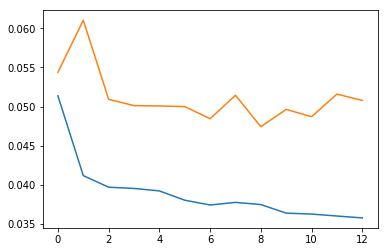

In [22]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(res[1][0].history['loss'])
plt.plot(res[1][0].history['val_loss'])



In [7]:
def nvidia_net_mod():
    """
    neural network from Nvidia paper
    """
    model=Sequential()

    model.add(Cropping2D(cropping=((50,20), (0,0)), \
                         input_shape=(160,320,3)))

    model.add(Lambda(lambda x: (x / 255.0) - 0.5))

    model.add(Convolution2D(24, 5, 5,  border_mode='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(36, 5, 5, border_mode='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Dropout(0.5))

    model.add(Convolution2D(48, 5, 5, border_mode='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))

    model.add(Dropout(0.5))

    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(Flatten())


    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))
    return model

In [64]:
size=(40,80)

def preprocessing_yuv(im):
    return cv2.cvtColor(im, cv2.COLOR_BGR2YUV)

In [65]:
def preprocessing_yuv(im):
    return cv2.cvtColor(im, cv2.COLOR_BGR2YUV)

params={'get_model':nvidia_net, 'correction':0.2, \
       'preprocessing':preprocessing_yuv,'optimizer':'adam','gpu':'1','name':'nvidia_net_02_yuv'}

q=train_model(**params)

In [ ]:
q=train_model(**params)

Instructions for updating:
Please switch to tf.summary.merge_all.
Epoch 1/100
95220/95220 [==============================] - 128s - loss: 0.0272 - mean_squared_error: 0.0272 - val_loss: 0.0426 - val_mean_squared_error: 0.0426
Epoch 2/100
95220/95220 [==============================] - 127s - loss: 0.0236 - mean_squared_error: 0.0236 - val_loss: 0.0446 - val_mean_squared_error: 0.0446
Epoch 3/100
95220/95220 [==============================] - 126s - loss: 0.0227 - mean_squared_error: 0.0227 - val_loss: 0.0410 - val_mean_squared_error: 0.0410
Epoch 4/100
95220/95220 [==============================] - 126s - loss: 0.0224 - mean_squared_error: 0.0224 - val_loss: 0.0426 - val_mean_squared_error: 0.0426
Epoch 5/100
95220/95220 [==============================] - 125s - loss: 0.0221 - mean_squared_error: 0.0221 - val_loss: 0.0418 - val_mean_squared_error: 0.0418
Epoch 6/100
95220/95220 [==============================] - 127s - loss: 0.0221 - mean_squared_error: 0.0221 - val_loss: 0.0405 - val_m

In [33]:
def nvidia_net_mode():
    """
    neural network from Nvidia paper
    """
    model=Sequential()
    
    #model.add(Cropping2D(cropping=((50,20), (0,0)), \
    #                     input_shape=(160,320,3)))

    #model.add(Lambda(lambda x: (x / 255.0) - 0.5))
    
    model.add(Convolution2D(24, 5, 5,  border_mode='valid', activation='relu',input_shape= (90, 320, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(36, 5, 5, border_mode='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.25))

    model.add(Convolution2D(48, 5, 5, border_mode='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    
    model.add(Dropout(0.25))

    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(Flatten())
    

    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))
    return model

In [34]:
from skimage.exposure import equalize_adapthist
def preprocess_v3(X):
    return equalize_adapthist(X,clip_limit=0.2)[50:-20,:,:]-0.5

params={'get_model':nvidia_net_mode, 'correction':0.2, \
       'preprocessing':preprocess_v3,'optimizer':'adam','gpu':'1','name':'nvidia_net_02_firsttrack_adapthist'}

q1=train_model(**params)

Instructions for updating:
Please switch to tf.summary.merge_all.
Epoch 1/100


/root/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


 7936/95220 [=>............................] - ETA: 1908s - loss: 0.0156 - mean_squared_error: 0.0156

KeyboardInterrupt: 

In [71]:
q[0].history

{'loss': [0.027872528848597242,
  0.023772440226801403,
  0.022858756994079375,
  0.022593041296091382,
  0.022215506919643829],
 'mean_squared_error': [0.027872528854856918,
  0.023772440016006778,
  0.022858756969979622,
  0.022593041315026905,
  0.022215506972694591],
 'val_loss': [0.034854509997912633,
  0.048999133569899427,
  0.036253391024005668,
  0.04044452177420739,
  0.041975370558199061],
 'val_mean_squared_error': [0.034854509767585543,
  0.048999133780198073,
  0.036253390863778129,
  0.040444521553894525,
  0.041975370683376825]}